In [1]:
import pandas as pd
import configparser
import os
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 50)

In [ ]:
# NEO4J_PROPERTIES_FILE = '/Users/zachblumenfeld/devtools/auth/aura-p2p-fd.ini'

In [2]:
## Using an ini file for credentials, otherwise providing defaults
uri = "bolt://localhost:7687"   # Hoặc thay đổi nếu cổng khác
username = "neo4j"              # Tên đăng nhập của Neo4j
password = "12345678"      # Mật khẩu của Neo4j

# if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
#     config = configparser.RawConfigParser()
#     config.read(NEO4J_PROPERTIES_FILE)
#     HOST = config['NEO4J']['HOST']
#     USERNAME = config['NEO4J']['USERNAME']
#     PASSWORD = config['NEO4J']['PASSWORD']
#     print('Using custom database properties')
# else:
#     print('Could not find database properties file, using defaults')

In [4]:
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience(uri, auth=(username, password))

In [5]:
def check_gds_connection(uri, username, password):
    try:
        # Kiểm tra xem graphdatascience đã được cài chưa
        import graphdatascience
        from graphdatascience import GraphDataScience

        print("✅ Thư viện 'graphdatascience' đã được cài đặt thành công.")

        # Kết nối tới Neo4j
        gds = GraphDataScience(uri, auth=(username, password))

        # Kiểm tra phiên bản để xác minh kết nối
        version = gds.version()
        print(f"✅ Đã kết nối tới Neo4j. Phiên bản GDS: {version}")

        return gds

    except ImportError:
        print("❌ Thư viện 'graphdatascience' chưa được cài đặt. Vui lòng cài đặt bằng lệnh:")
        print("python -m pip install graphdatascience")

    except Exception as e:
        print(f"❌ Lỗi khi kết nối với Neo4j: {e}")

# Thông tin kết nối của bạn
uri = "bolt://localhost:7687"   # Hoặc thay đổi nếu cổng khác
username = "neo4j"              # Tên đăng nhập của Neo4j
password = "12345678"      # Mật khẩu của Neo4j

# Gọi hàm để kiểm tra
check_gds_connection(uri, username, password)


✅ Thư viện 'graphdatascience' đã được cài đặt thành công.
✅ Đã kết nối tới Neo4j. Phiên bản GDS: 2.9.0


In [6]:
def clear_graph_by_name(g_name):
    if gds.graph.exists(g_name).exists:
        g = gds.graph.get(g_name)
        gds.graph.drop(g)

def clear_all_graphs():
    g_names = gds.graph.list().graphName.tolist()
    for g_name in g_names:
        g = gds.graph.get(g_name)
        gds.graph.drop(g)

def identifier_degrees(user_label, degree_property):
    g_name = 'id-projection'
    clear_graph_by_name(g_name)
    g, _  = gds.graph.project(g_name, [user_label, 'Card', 'Device', 'IP'],{
        'HAS_CC': {'orientation': 'REVERSE'},
        'HAS_IP': {'orientation': 'REVERSE'},
        'USED': {'orientation': 'REVERSE'}
    })
    gds.degree.mutate(g, mutateProperty=degree_property)
    gds.graph.writeNodeProperties(g, [degree_property], ['Card', 'Device', 'IP'])
    g.drop()

In [9]:
# total node counts
gds.run_cypher('''
    CALL apoc.meta.stats()
    YIELD labels
    UNWIND keys(labels) AS nodeLabel
    RETURN nodeLabel, labels[nodeLabel] AS nodeCount
''')

,nodeLabel,nodeCount
0,User,33731
1,Device,51451
2,Card,118818
3,IP,585855


In [10]:
# total relationship counts
gds.run_cypher('''
    CALL apoc.meta.stats()
    YIELD relTypesCount
    UNWIND keys(relTypesCount) AS relationshipType
    RETURN relationshipType, relTypesCount[relationshipType] AS relationshipCount
''')

,relationshipType,relationshipCount
0,USED,55023
1,HAS_IP,1488844
2,HAS_CC,128060
3,REFERRED,1870
4,P2P,102828


In [11]:
#fraud money transfer flags
gds.run_cypher('MATCH(u:User) RETURN u.fraudMoneyTransfer AS fraudMoneyTransfer, count(u) AS cnt')

,fraudMoneyTransfer,cnt
0,0,33490
1,1,241


In [12]:
# Thiết lập nhãn mới giúp truy vấn dễ dàng hơn 
gds.run_cypher('MATCH(u:User) WHERE u.fraudMoneyTransfer=1 SET u:FlaggedUser RETURN count(u)')

,count(u)
0,241


In [14]:
#Gán độ cho nút card, device, ip có kết nối tới người dùng
identifier_degrees('User', 'degree')
#Gán độ cho nút card, device, ip có kết nối tới người dùng gian lận
identifier_degrees('FlaggedUser', 'flaggedDegree')

#Tính % người dùng gian lận / người dùng của nút card, device, ip 
gds.run_cypher('''
    MATCH(n) WHERE n:Card OR n:Device OR n:IP
    SET n.flaggedRatio = toFloat(n.flaggedDegree)/toFloat(n.degree)
''')

""


In [16]:
print('Flagged User Ratio for Card Count')
#In ra % các nút Card có kết nối ít nhất 2 người dùng (degree > 1)
gds.run_cypher('''
    MATCH(n:Card) WHERE n.degree > 1
    WITH COUNT(n) AS total
    MATCH(n:Card) WHERE n.degree > 1
    WITH n, total, CASE
    WHEN n.flaggedRatio=0 THEN '0'
    WHEN n.flaggedRatio=1 THEN '1'
    ELSE 'Between 0-1' END AS flaggedUserRatio
    WITH flaggedUserRatio, total, COUNT(n) AS count
    RETURN flaggedUserRatio, count, round(toFloat(count)/total, 3) AS percentCount
    ORDER BY flaggedUserRatio
''')

Flagged User Ratio for Card Count


,flaggedUserRatio,count,percentCount
0,0,8185,0.964
1,1,31,0.004
2,Between 0-1,274,0.032


In [20]:
print('Flagged User Ratio for Device Count')
#In ra % các nút Deveice có kết nối ít nhất 2 người dùng (degree > 1)
gds.run_cypher('''
    MATCH(n:Device) WHERE n.degree > 1
    WITH COUNT(n) AS total
    MATCH(n:Device) WHERE n.degree > 1
    WITH n, total, CASE
    WHEN n.flaggedRatio=0 THEN '0'
    WHEN n.flaggedRatio=1 THEN '1'
    ELSE 'Between 0-1' END AS flaggedUserRatio
    WITH flaggedUserRatio, total, COUNT(n) AS count
    RETURN flaggedUserRatio, count, round(toFloat(count)/total, 3) AS percentCount
    ORDER BY flaggedUserRatio
''')

Flagged User Ratio for Card Count


,flaggedUserRatio,count,percentCount
0,0,2655,0.967
1,1,2,0.001
2,Between 0-1,88,0.032


In [23]:
# Clear graph nếu đã tồn tại
clear_graph_by_name('comm-projection')

g, _ = gds.graph.project('comm-projection', ['User','Card', 'Device'], {
    'HAS_CC': {'orientation': 'UNDIRECTED'},
    'USED': {'orientation': 'UNDIRECTED'},
    'P2P': {'orientation': 'NATURAL', 'aggregation': 'SINGLE'}
})

df = gds.louvain.write(g, writeProperty='louvainCommunityId')
g.drop()
df
#writeMillis: thời gian ghi kết quả phân cụm vào thuộc tính louvainCommunityId
#nodePropertiesWritten: Số lượng nút được phân cụm là 204,000
#modularity: Đây là chỉ số Modularity cuối cùng, đạt 0.981
#modularities: Mỗi giá trị tương ứng với modularity ở từng cấp độ phân cụm. Giá trị modularity tăng dần qua các cấp độ, cho thấy thuật toán tiếp tục cải thiện phân cụm cho đến khi đạt ngưỡng tốt nhất.
#ranLevels:Thuật toán đã chạy 10 cấp độ phân cụm để đạt được modularity tối ưu.
#communityCount:Số lượng cộng đồng được phát hiện là 11,662
#communityDistributionmin: 1 → Vẫn có cộng đồng nhỏ nhất chỉ với 1 nút.
# max: 3643 → Cộng đồng lớn nhất có 3,643 nút.
# mean: 17.49 → Kích thước trung bình mỗi cộng đồng là khoảng 17 nút.
#còn laij là hiệu năng cấu hình 

 Louvain: 100%|██████████| 100.0/100 [00:02<00:00, 42.32%/s, status: FINISHED]                                                                   


writeMillis                                                                                                                                                                                                                                                                                                                                                                                                                  93
nodePropertiesWritten                                                                                                                                                                                                                                                                                                                                                                                                    204000
modularity                                                                                                                                                              

In [24]:
# In cộng đồng và tỉ lệ người dùng gian lận 
print("Louvain Communities Ordered by count of Flagged Users")
gds.run_cypher('''
    MATCH (u:User)
    WITH u.louvainCommunityId AS community,
        count(u) AS cnt,
        sum(u.fraudMoneyTransfer) as flaggedCount
    RETURN community,
        cnt,
        flaggedCount,
        toFloat(flaggedCount)/toFloat(cnt) AS flaggedRatio
    ORDER BY flaggedCount DESC LIMIT 100
''')


Louvain Communities Ordered by count of Flagged Users


,community,cnt,flaggedCount,flaggedRatio
0,69403,133,7,0.052632
1,182732,7,4,0.571429
2,179564,3,3,1.000000
3,74786,7,3,0.428571
4,173037,240,3,0.012500
...,...,...,...,...
95,190690,4,1,0.250000
96,170482,4,1,0.250000
97,186370,4,1,0.250000
98,43256,228,1,0.004386


In [25]:
#Part 2: Resolving Fraud Communities using Entity Resolution and Community Detection

#Tạo quan hệ P2P_WITH_SHARED_CARD với người dùng từng có giao dịch P2P và sử dụng chung card
gds.run_cypher('''
    MATCH (u1:User)-[r:P2P]->(u2)
    WITH u1, u2, count(r) AS cnt
    MATCH (u1)-[:HAS_CC]->(n)<-[:HAS_CC]-(u2)
    WITH u1, u2, count(DISTINCT n) AS cnt
    MERGE(u1)-[s:P2P_WITH_SHARED_CARD]->(u2)
    RETURN count(DISTINCT s) AS cnt
''')

,cnt
0,6240


In [26]:

#Tạo quan hệ SHARED_IDS giữa các người dùng nếu họ chia sẻ nhiều hơn hai thông tin nhận dạng (ID): thẻ tín dụng, thiết bị, hoặc địa chỉ IP
#Lọc các ID ít phổ biến (số lượng kết nối <= 10) nhằm tránh những gây nhiễu do các ID chung (thiết bị công cộng)
gds.run_cypher('''
    MATCH (u1:User)-[:HAS_CC|USED]->(n)<-[:HAS_CC|USED]-(u2)
    WHERE n.degree <= 10 AND id(u1) < id(u2) 
    WITH u1, u2, count(DISTINCT n) as cnt
    MATCH (u1)-[:HAS_CC|USED|HAS_IP]->(m)<-[:HAS_CC|USED|HAS_IP]-(u2)
    WITH u1, u2, count(DISTINCT m) as cnt
    WHERE cnt > 2
    MERGE(u1)-[s:SHARED_IDS]->(u2)
    RETURN count(DISTINCT s)
''')

,count(DISTINCT s)
0,5316


In [27]:
# WCC là thuật toán dùng để xác định các nhóm nút liên thông yếu trong một đồ thị vô hướng.
# Một thành phần liên thông yếu là tập hợp các nút mà bất kỳ hai nút nào cũng được kết nối với nhau bỏ qua hướng của cạnh.
# Ví dụ:
# Nếu User A chia sẻ thẻ với User B, và User B từng giao dịch với User C qua thẻ tín dụng, thì cả ba người sẽ thuộc cùng một thành phần liên thông yếu
# WCC giúp phân tách đồ thị thành các nhóm nhỏ hơn mà các nút trong mỗi nhóm đều có liên kết trực tiếp hoặc gián tiếp với nhau.
# Mỗi thành phần liên thông yếu (WCC) có thể được coi là một cộng đồng hoặc một nhóm các thực thể có mối liên hệ chặt chẽ.

# Clear đồ thị đã tồn tại 
clear_graph_by_name('comm-projection')
# Tạo đồ thị mà các người dùng được kết nối với nhau nếu chia sẻ một thông tin nhận dạng hoặc từng giao dịch với nhau qua thẻ tín dụng.
g, _ = gds.graph.project('comm-projection', ['User'], {
    'SHARED_IDS': {'orientation': 'UNDIRECTED'},
    'P2P_WITH_SHARED_CARD': {'orientation': 'UNDIRECTED'}
})
df = gds.wcc.write(g, writeProperty='wccId')
g.drop()
df

writeMillis                                                                                                                                                                                                                                                                                                                  245
nodePropertiesWritten                                                                                                                                                                                                                                                                                                      33731
componentCount                                                                                                                                                                                                                                                                                                             28202
componentDistribution                

In [28]:
# Gán nhãn nguy cơ gian lận cho người dùng có trong cộng đồng có cá nhân gian lận 
gds.run_cypher('''
    MATCH (f:FlaggedUser)
    WITH collect(DISTINCT f.wccId) AS flaggedCommunities
    MATCH(u:User) WHERE u.wccId IN flaggedCommunities
    SET u:FraudRiskUser
    SET u.fraudRisk=1
    RETURN count(u)
''')

,count(u)
0,452


In [29]:
# Gán nhãn người dùng còn lại
gds.run_cypher('''
    MATCH (u:User) WHERE NOT u:FraudRiskUser
    SET u.fraudRisk=0
    RETURN count(u)
''')

,count(u)
0,33279


In [30]:
#Phân loại các cộng đồng theo kích thước.
#Thống kê số lượng người dùng và số người dùng gian lận trong mỗi loại cộng đồng.
gds.run_cypher( '''
    MATCH (u:User)
    WITH u.wccId AS community, count(u) AS cSize, sum(u.fraudRisk) AS cFraudSize
    WITH community, cSize, cFraudSize,
    CASE
        WHEN cSize=1 THEN ' 1'
        WHEN cSize=2 THEN ' 2'
        WHEN cSize=3 THEN ' 3'
        WHEN cSize>3 AND cSize<=10 THEN ' 4-10'
        WHEN cSize>10 AND cSize<=50 THEN '11-50'
        WHEN cSize>10 THEN '>50' END AS componentSize
    RETURN componentSize, 
        count(*) AS numberOfComponents, 
        sum(cSize) AS totalUserCount, 
        sum(cFraudSize) AS fraudUserCount 
    ORDER BY componentSize
''')

,componentSize,numberOfComponents,totalUserCount,fraudUserCount
0,1,24282,24282,118
1,2,3165,6330,144
2,3,481,1443,63
3,4-10,258,1246,68
4,11-50,15,255,59
5,>50,1,175,0


In [31]:
# Việc gán nhãn FraudRiskUser đã giúp phát hiện thêm 211 tài khoản rủi ro mới.
# Điều này dẫn đến tăng 87.5% số lượng tài khoản bị đánh dấu rủi ro, gần gấp đôi so với trước đó.
# Khi nhìn vào dòng tiền, 65% các giao dịch liên quan đến các tài khoản bị gắn cờ là từ các tài khoản rủi ro mới.
# Điều này chứng minh rằng các tài khoản mới bị gán nhãn thực sự có liên quan chặt chẽ đến mạng lưới gian lận.
gds.run_cypher('''
   MATCH (:FlaggedUser)-[r:P2P]-(u)  WHERE NOT u:FlaggedUser
   WITH toFloat(sum(r.totalAmount)) AS p2pTotal
   MATCH (u:FraudRiskUser)-[r:P2P]-(:FlaggedUser) WHERE NOT u:FlaggedUser
   WITH p2pTotal,  toFloat(sum(r.totalAmount)) AS fraudRiskP2pTotal
   RETURN round((fraudRiskP2pTotal)/p2pTotal,3) AS p
''').p[0]

0.652

In [32]:
# Mặc dù 211 tài khoản rủi ro mới chỉ chiếm <1% tổng số người dùng, nhưng lại liên quan đến 12.7% tổng dòng tiền trong mạng.
# Điều này chứng minh rằng các tài khoản rủi ro mới có mức độ liên kết và ảnh hưởng rất lớn.
# Việc gán nhãn các tài khoản này đã giúp phát hiện và kiểm soát thêm một phần lớn dòng tiền rủi ro.
# Nếu không gán nhãn, những giao dịch này sẽ dễ bị bỏ qua và có thể dẫn đến rủi ro cao hơn.
gds.run_cypher('''
   MATCH (:User)-[r:P2P]->()
   WITH toFloat(sum(r.totalAmount)) AS p2pTotal
   MATCH (u:FraudRiskUser)-[r:P2P]-() WHERE NOT u:FlaggedUser
   WITH p2pTotal, toFloat(sum(r.totalAmount)) AS fraudRiskP2pTotal
   RETURN round((fraudRiskP2pTotal)/p2pTotal,3) AS p
''').p[0]

0.127

In [33]:
#Tinh % số người khả năng gian lận / số người kết nối tới các nút định danh 
identifier_degrees('FraudRiskUser', 'fraudRiskDegree')

gds.run_cypher('''
    MATCH(n) WHERE n:Card OR n:Device OR n:IP
    SET n.fraudRiskRatio = toFloat(n.fraudRiskDegree)/toFloat(n.degree)
''')

""


In [38]:
#Truy vấn lại dựa trên gía trị fraudRiskRatio
gds.run_cypher('''
    MATCH(n:Card) WHERE n.degree > 1
    WITH COUNT(n) AS total
    MATCH(n:Card) WHERE n.degree > 1
    WITH n, total, CASE
    WHEN n.fraudRiskRatio=0 THEN '0'
    WHEN n.fraudRiskRatio=1 THEN '1'
    ELSE 'Between 0-1' END AS fraudRiskRatio
    WITH fraudRiskRatio, total, COUNT(n) AS count
    RETURN fraudRiskRatio, count, round(toFloat(count)/total, 3) AS percentCount
    ORDER BY fraudRiskRatio
''')

,fraudRiskRatio,count,percentCount
0,0,8114,0.956
1,1,351,0.041
2,Between 0-1,25,0.003


In [39]:
gds.run_cypher('''
    MATCH(n:Device) WHERE n.degree > 1
    WITH COUNT(n) AS total
    MATCH(n:Device) WHERE n.degree > 1
    WITH n, total, CASE
    WHEN n.fraudRiskRatio=0 THEN '0'
    WHEN n.fraudRiskRatio=1 THEN '1'
    ELSE 'Between 0-1' END AS fraudRiskRatio
    WITH fraudRiskRatio, total, COUNT(n) AS count
    RETURN fraudRiskRatio, count, round(toFloat(count)/total, 3) AS percentCount
    ORDER BY fraudRiskRatio
''')

,fraudRiskRatio,count,percentCount
0,0,2605,0.949
1,1,92,0.034
2,Between 0-1,48,0.017


In [7]:
# Xác định các tài khoản chưa được đánh dấu đáng ngờ bằng cách đánh giá mức độ liên kết của họ với các thông tin nhận dạng (IDs) có rủi ro cao.
# Sử dụng fraudRiskRatio (tỷ lệ rủi ro) đã tính trước đó cho mỗi Card, Device, và IP để làm trọng số.
gds.run_cypher('''
    MATCH(f:FraudRiskUser)-[:HAS_CC|HAS_IP|USED]->(n)
    WITH DISTINCT n
    MATCH(u:User)-[:HAS_CC|HAS_IP|USED]->(n) WHERE NOT u:FraudRiskUser
    WITH left(u.guid,8) as uid,
        sum(n.fraudRiskRatio) AS totalIdFraudRisk,
        count(n) AS numberFraudRiskIds
    WITH uid, totalIdFraudRisk,
        numberFraudRiskIds,
        totalIdFraudRisk/toFloat(numberFraudRiskIds) AS averageFraudIdRisk
    WHERE averageFraudIdRisk >= 0.25
    RETURN uid, totalIdFraudRisk, numberFraudRiskIds, averageFraudIdRisk
    ORDER BY totalIdFraudRisk DESC LIMIT 10
''')

,uid,totalIdFraudRisk,numberFraudRiskIds,averageFraudIdRisk
0,50fd11c0,7.405514,28,0.264483
1,b41b9e3b,6.488064,22,0.294912
2,a982e8fc,3.928543,13,0.302196
3,60b71ab9,2.020481,7,0.288640
4,bc1eb835,2.010309,5,0.402062
5,1b1a78a9,1.925455,5,0.385091
6,f2b8a068,1.693808,6,0.282301
7,1c773976,1.594978,5,0.318996
8,a2f748e3,1.570455,4,0.392614
9,7524a090,1.527338,5,0.305468


In [8]:
# Đánh dấu các ID (Card, Device, IP) được chia sẻ với các tài khoản rủi ro bằng nhãn FraudSharedId.
# Ví dụ: Một Card được sử dụng bởi một FraudRiskUser sẽ được đánh dấu là FraudSharedId
# Tính toán và gán trọng số ngược (inverseDegreeWeight) cho các mối quan hệ, giúp đánh giá mức độ rủi ro của từng mối liên kết.
# Nếu một ID được chia sẻ bởi ít tài khoản, giá trị trọng số sẽ cao hơn.
# Nếu một ID được chia sẻ bởi nhiều tài khoản, giá trị trọng số sẽ thấp hơn.
# ID càng ít người dùng chia sẻ, càng đáng nghi và nguy cơ cao hơn.
# Nếu một ID được sử dụng bởi nhiều tài khoản, thì khả năng ID đó là một ID phổ biến (như thiết bị công cộng) và ít rủi ro hơn.

gds.run_cypher('''
    MATCH(f:FraudRiskUser)-[:HAS_CC|HAS_IP|USED]->(n)
    WITH DISTINCT n
    MATCH(n)<-[r:HAS_CC|HAS_IP|USED]-(u)
    SET n:FraudSharedId
    SET r.inverseDegreeWeight = 1.0/(n.degree-1.0)
    RETURN count(DISTINCT n)
''')

,count(DISTINCT n)
0,18182


In [9]:
# Tìm cách mở rộng các cộng đồng rủi ro gian lận bằng cách xác định mối quan hệ giữa các người dùng có khả năng liên quan đến nhau.
# Sử dụng thuật toán Node Similarity, dựa trên tính toán chỉ số tương đồng Jaccard.
# Clear đồ thì nếu đã tồn tại
clear_graph_by_name('similarity-projection')

g, _ = gds.graph.project('similarity-projection', ['User', 'FraudSharedId'], ['HAS_CC', 'USED', 'HAS_IP'],
                         relationshipProperties=['inverseDegreeWeight'])



df = gds.nodeSimilarity.write(g, writeRelationshipType='SIMILAR_IDS', writeProperty='score',
                              similarityCutoff=0.01, relationshipWeightProperty='inverseDegreeWeight')
g.drop()
df

 Node Similarity: 100%|██████████| 100.0/100 [01:10<00:00,  8.17s/%, status: FINISHED]                         

preProcessingMillis                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         9
computeMillis                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [10]:
# Xác định các tài khoản User tương đồng với các FraudRiskUser
# Các tài khoản có totalScore cao cần được kiểm tra kỹ lưỡng vì chúng có nhiều liên kết với các tài khoản rủi ro.
gds.run_cypher('''
    MATCH (f:FraudRiskUser)
    WITH f.wccId AS componentId, count(*) AS numberOfUsers, collect(f) AS users
    UNWIND users AS f
    MATCH (f)-[s:SIMILAR_IDS]->(u:User) WHERE NOT u:FraudRiskUser AND numberOfUsers > 2
    RETURN u.guid AS userId, sum(s.score) AS totalScore, collect(DISTINCT componentId) AS closeToCommunityIds 
    ORDER BY totalScore DESC
''')

,userId,totalScore,closeToCommunityIds
0,3b4284c78a2c54de93012d0e0da83414,0.780392,[432]
1,0b3f278ff6b348fb1a599479d9321cd9,0.406882,[4615]
2,99d857cf888723db4ab2c19e42ac2b4c,0.367563,[4615]
3,55447b3000b48335d3b18557c43ba70a,0.136346,[4615]
4,9d428858704b6a1f4c618146ae4176da,0.113550,[4615]
5,f3c3fa16c8d095c257452f3287991cef,0.113478,[4615]
6,f0ec0c4c8cf74ebdf1ace4c366e58873,0.111970,[4615]
7,d4809c7afb2413f5e245bea5bfb086c6,0.103041,[4615]
8,7f4049aa723b7630ebd621ce52e0d99f,0.098467,[4615]
9,48ab157818d5d6e31d4808e624a93846,0.077805,[4615]


In [11]:
# Xây dựng các đặc trưng cho máy học 
# Tạo đặc trưng về kích thước cộng đồng (communitySize) cho mỗi tài khoản người dùng (User) dựa trên thành phần liên thông yếu (WCC).
# Xác định xem một tài khoản có thuộc về cộng đồng lớn hơn 1 người hay không (partOfCommunity).
# Cập nhật hai đặc trưng này vào mỗi nút User để sử dụng cho huấn luyện mô hình Machine Learning.
gds.run_cypher('''
    MATCH (u:User)
    WITH u.wccId AS componentId, count(*) AS communitySize, collect(u) AS users
    WITH communitySize, toInteger(communitySize > 1) AS partOfCommunity, users
    UNWIND users as u
    SET u.communitySize = communitySize
    SET u.partOfCommunity = partOfCommunity;
''')

""


In [12]:
# Tạo đồ thị (p2p-features) với các loại mối quan hệ liên quan đến giao dịch và chia sẻ ID.
# Tính toán các đặc trưng trung tâm (Centrality Features):
# Degree Centrality: Số lượng kết nối của một tài khoản.
# PageRank Centrality: Đo lường mức độ ảnh hưởng của tài khoản trong mạng lưới giao dịch.
# Lưu các đặc trưng vào các thuộc tính của từng User để phục vụ cho các thuật toán phát hiện gian lận.
# clear the graph if it exists beforehand
clear_graph_by_name('p2p-features')

# Payment Centrality & Influence Features
g, _ = gds.graph.project('p2p-features', ['User'], {
    'P2P': {'type': 'P2P', 'orientation': 'NATURAL', 'aggregation': 'SUM', 'properties': ['totalAmount']},
    'P2P_REVERSE': {'type': 'P2P', 'orientation': 'REVERSE', 'aggregation': 'SUM', 'properties': ['totalAmount']},
    'SHARED_IDS': {'type': 'SHARED_IDS', 'orientation': 'UNDIRECTED'},
    'P2P_WITH_SHARED_CARD': {'type': 'P2P_WITH_SHARED_CARD', 'orientation': 'NATURAL'}
})
gds.degree.write(g, relationshipTypes=['SHARED_IDS'], writeProperty='sharedIdsDegree')
gds.pageRank.write(g, relationshipTypes=['P2P_WITH_SHARED_CARD'], maxIterations=1000,
                   writeProperty='p2pSharedCardPageRank')
gds.pageRank.write(g, relationshipTypes=['P2P'], maxIterations=1000, writeProperty='p2pSentPageRank')
gds.pageRank.write(g, relationshipTypes=['P2P_REVERSE'], maxIterations=1000, relationshipWeightProperty='totalAmount',
                   writeProperty='p2pReceivedWeightedPageRank')
gds.degree.write(g, relationshipTypes=['P2P_REVERSE'], relationshipWeightProperty='totalAmount',
                 writeProperty='p2pReceivedWeightedDegree')
g.drop()

 PageRank: 100%|██████████| 100.0/100 [00:00<00:00, 381.58%/s, status: FINISHED]                        


graphName                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       p2p-features
database                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [13]:
# Tính toán số lượng kết nối (Degree Centrality) giữa các tài khoản User và các ID (Card, Device, IP).
# Ghi các đặc trưng này vào các thuộc tính mới trên nút User, bao gồm:
# cardDegree: Số lượng thẻ tín dụng mà một User đã sử dụng.
# deviceDegree: Số lượng thiết bị mà một User đã sử dụng.
# ipDegree: Số lượng địa chỉ IP mà một User đã kết nối.
# clear the graph if it exists beforehand
clear_graph_by_name('p2p-features')

# User Id Centrality Features
g, _ = gds.graph.project('user-centrality-features', ['User', 'Card', 'Device', 'IP'], ['HAS_CC', 'HAS_IP', 'USED'])
gds.degree.mutate(g, nodeLabels=['User', 'Card'], relationshipTypes=['HAS_CC'], mutateProperty='cardDegree')
gds.degree.mutate(g, nodeLabels=['User', 'Device'], relationshipTypes=['USED'], mutateProperty='deviceDegree')
gds.degree.mutate(g, nodeLabels=['User', 'IP'], relationshipTypes=['HAS_IP'], mutateProperty='ipDegree')
gds.graph.writeNodeProperties(g, ['cardDegree', 'deviceDegree', 'ipDegree'], ['User'])
g.drop()

graphName                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           user-centrality-features
database                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [6]:
# Machine Learning Training & Evaluation
# Get and Prepare Data
df = gds.run_cypher('''
    MATCH(u:User)
    RETURN u.guid AS guid,
        u.wccId AS wccId,
        u.fraudRisk AS fraudRisk,
        u.fraudMoneyTransfer AS fraudMoneyTransfer,
        u.sharedIdsDegree AS sharedIdsDegree,
        u.p2pSharedCardPageRank AS p2pSharedCardPageRank,
        u.p2pSentPageRank AS p2pSentPageRank,
        u.p2pReceivedWeightedPageRank AS p2pReceivedWeightedPageRank,
        u.p2pReceivedWeightedDegree AS p2pReceivedWeightedDegree,
        u.ipDegree AS ipDegree,
        u.cardDegree AS cardDegree,
        u.deviceDegree AS deviceDegree,
        u.communitySize AS communitySize,
        u.partOfCommunity AS partOfCommunity
''')
df

,guid,wccId,fraudRisk,fraudMoneyTransfer,sharedIdsDegree,p2pSharedCardPageRank,p2pSentPageRank,p2pReceivedWeightedPageRank,p2pReceivedWeightedDegree,ipDegree,cardDegree,deviceDegree,communitySize,partOfCommunity
0,be0222d26897046dc92ae2929d3427e7,0,0,0,0.0,0.150000,0.175463,0.414298,10.0,21.0,3.0,4.0,1,0
1,59515432f0e2e79b83e9524c94f7f86e,1,0,0,0.0,0.150000,0.310576,0.150422,10.0,7.0,1.0,1.0,1,0
2,ba1f4324c66ee093478d41a6826a3649,2,0,0,0.0,0.150000,0.277500,0.150000,160.0,8.0,2.0,1.0,1,0
3,8a18e1625e35a9f66abfd7bd2d04f0b3,3,0,0,0.0,0.150000,0.230177,0.319779,100.0,135.0,12.0,2.0,1,0
4,9f705a0107acc25a57f9e6aa8436a08e,4,0,0,0.0,0.150000,0.391428,0.150000,2703.6,169.0,9.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33726,f3693169dcc9064114a171c5c2f485b5,33726,0,0,0.0,0.150000,0.297005,0.451011,5.0,14.0,2.0,2.0,1,0
33727,10f7f048645c602de3fae7c2cf81b254,27912,0,0,1.0,0.999999,0.371382,1.632799,150.0,5.0,4.0,4.0,2,1
33728,d3a4469957800636802a8de4874af1bc,33728,0,0,0.0,0.150000,0.150000,0.277500,0.0,38.0,2.0,0.0,1,0
33729,4698ccb2e4b07b1974741f634115e49b,33729,0,0,0.0,0.150000,0.181054,0.170451,10.0,1.0,1.0,0.0,1,0


In [7]:
# X: Tập dữ liệu đặc trưng đầu vào cho mô hình, loại bỏ các cột không cần thiết:
# Loại bỏ fraudRisk, fraudMoneyTransfer (vì đây là mục tiêu dự đoán).
# Loại bỏ wccId và guid (không mang giá trị cho mô hình học máy).
X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid'])
# y: Biến mục tiêu (target variable):
# df.fraudRisk - df.fraudMoneyTransfer:
# Nếu fraudRisk = 1 và fraudMoneyTransfer = 0 → tài khoản nguy cơ rủi ro → y = 1.
# Nếu fraudRisk = 1 và fraudMoneyTransfer = 1 → tài khoản đã chuyển tiền gian lận → y = 0.
# Nếu fraudRisk = 0 → tài khoản an toàn → y = 0.
y = df.fraudRisk - df.fraudMoneyTransfer

In [8]:
print(X)

       sharedIdsDegree  p2pSharedCardPageRank  p2pSentPageRank  \
0                  0.0               0.150000         0.175463   
1                  0.0               0.150000         0.310576   
2                  0.0               0.150000         0.277500   
3                  0.0               0.150000         0.230177   
4                  0.0               0.150000         0.391428   
...                ...                    ...              ...   
33726              0.0               0.150000         0.297005   
33727              1.0               0.999999         0.371382   
33728              0.0               0.150000         0.150000   
33729              0.0               0.150000         0.181054   
33730              0.0               0.150000         0.185296   

       p2pReceivedWeightedPageRank  p2pReceivedWeightedDegree  ipDegree  \
0                         0.414298                       10.0      21.0   
1                         0.150422                       

In [9]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
33726    0
33727    0
33728    0
33729    0
33730    0
Length: 33731, dtype: int64


In [10]:
# Chia tập train và test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
# Mô hình random forest 
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, random_state=0, max_depth=5, bootstrap=True, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
                       random_state=0)

Accuracy of random forrest classifier on test set: 0.84

Confusion Matrix: 


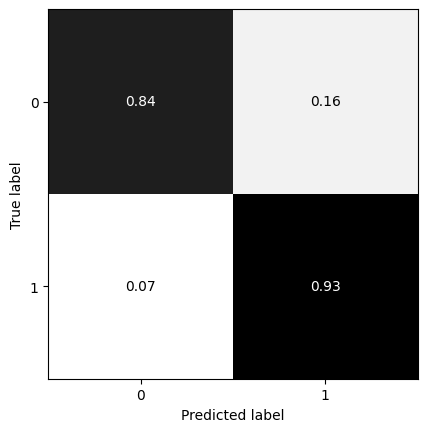

In [46]:
# Hiển thị ma trận nhầm lẫn (Confusion Matrix) để đánh giá chi tiết hiệu quả của mô hình.
# Các chỉ số trong Confusion Matrix:
# True Positive (TP): Dự đoán đúng tài khoản rủi ro.
# True Negative (TN): Dự đoán đúng tài khoản không rủi ro.
# False Positive (FP): Dự đoán nhầm tài khoản không rủi ro là rủi ro.
# False Negative (FN): Dự đoán nhầm tài khoản rủi ro là không rủi ro.
from sklearn.metrics import ConfusionMatrixDisplay
print('Accuracy of random forrest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test), display_labels=clf.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

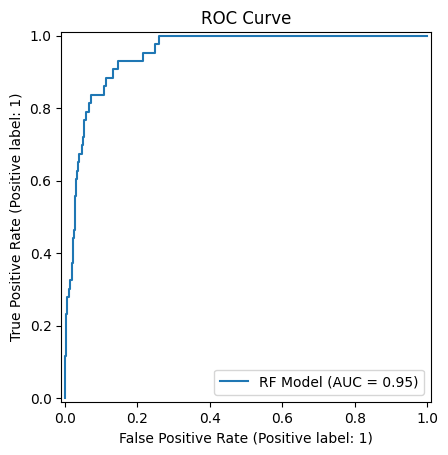

In [23]:
# Vẽ đồ thị ROC cho mô hình RandomForestClassifier.
# Giúp đánh giá trực quan khả năng phân loại của mô hình qua các mức ngưỡng phân loại khác nhau.
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(clf, X_test, y_test, name="RF Model")
_ = display.ax_.set_title("ROC Curve")

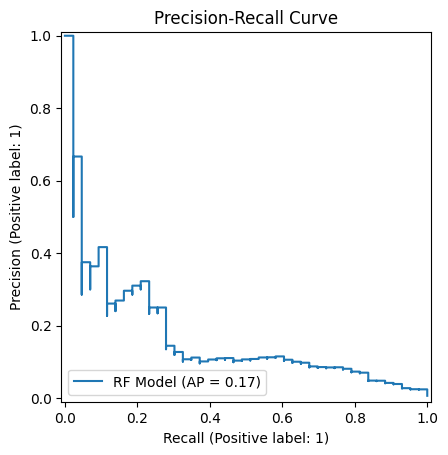

In [24]:
# Vẽ đồ thị Precision-Recall (PR Curve) cho mô hình.
# Giúp đánh giá mức độ chính xác (Precision) và khả năng thu hồi (Recall) của mô hình tại các ngưỡng khác nhau.
from sklearn.metrics import PrecisionRecallDisplay

y_prob = clf.predict_proba(X_test)
display = PrecisionRecallDisplay.from_predictions(y_test, y_prob[:, 1], name="RF Model")
_ = display.ax_.set_title("Precision-Recall Curve")

In [25]:
# Tính toán độ quan trọng của các đặc trưng bằng cách sử dụng Permutation Importance.
# Xác định những đặc trưng nào đóng góp nhiều nhất vào khả năng dự đoán của mô hình.
# Sắp xếp các đặc trưng theo mức độ quan trọng để hỗ trợ trong việc tối ưu hóa mô hình hoặc giảm số lượng đặc trưng.
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_train, y_train, random_state=0)
pd.DataFrame(abs(result['importances_mean']),index=X_train.columns).sort_values(0, ascending=False)

,0
partOfCommunity,0.110525
communitySize,0.105700
ipDegree,0.022539
sharedIdsDegree,0.019916
p2pSentPageRank,0.006352
p2pReceivedWeightedPageRank,0.004054
cardDegree,0.002290
p2pReceivedWeightedDegree,0.002149
p2pSharedCardPageRank,0.001119
deviceDegree,0.000311


In [26]:
# Retrieve High Probability predictions for non-fraud risk labeled data in the testset
# Lọc ra những tài khoản mà mô hình dự đoán có xác suất rủi ro cao (trên 0.88) nhưng thực tế chưa bị gán nhãn rủi ro.
# Liên kết thêm các thông tin như guid, wccId, communitySize để phân tích sâu hơn.
y_test_df = y_test.to_frame(name='cls')
y_test_df['predictedProbability']=y_prob[:, 1]
test_prob_df = y_test_df[(y_test_df.predictedProbability > 0.88) & (y_test_df.cls == 0)] \
    .join(df[['guid','wccId', 'communitySize']])
test_prob_df

,cls,predictedProbability,guid,wccId,communitySize
18992,0,0.902280,6a8845a1e7c682d27ea003baa717fd68,2859,18
15077,0,0.919707,bccaaa50640b11202434dc6c0a38e0e4,249,15
33419,0,0.916158,0f4864c3198dea15bc7148f8bb9c43c8,274,14
22345,0,0.881106,0249a67d54e83eaf9aa52fd7b127e35f,18799,3
20252,0,0.881727,e6383c630a92d3547be25b9b076a1fe5,18799,3
18711,0,0.882572,3ef622ff81c43c3ddc8b76db4dec34f3,2859,18
30656,0,0.882533,59a77d42d2ecb63d0cdf25834f8cf253,14,3


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
 
# Khởi tạo và huấn luyện MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32), 
    activation='relu', 
    solver='adam',
    max_iter=500,
    random_state=42, 
    verbose=True)
mlp.fit(X_train, y_train)

# Dự đoán và đánh giá
y_pred = mlp.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
# 4. Tính và hiển thị Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Iteration 1, loss = 0.48034390
Iteration 2, loss = 0.21665153
Iteration 3, loss = 0.21090630
Iteration 4, loss = 0.24115804
Iteration 5, loss = 0.15830179
Iteration 6, loss = 0.20365566
Iteration 7, loss = 0.16786722
Iteration 8, loss = 0.14188119
Iteration 9, loss = 0.27583389
Iteration 10, loss = 0.15558762
Iteration 11, loss = 0.16202257
Iteration 12, loss = 0.16165133
Iteration 13, loss = 0.16853074
Iteration 14, loss = 0.25069347
Iteration 15, loss = 0.13306920
Iteration 16, loss = 0.15741010
Iteration 17, loss = 0.26579321
Iteration 18, loss = 0.16736402
Iteration 19, loss = 0.17186837
Iteration 20, loss = 0.16380270
Iteration 21, loss = 0.14666104
Iteration 22, loss = 0.10321864
Iteration 23, loss = 0.14564348
Iteration 24, loss = 0.12319273
Iteration 25, loss = 0.14949806
Iteration 26, loss = 0.08377423
Iteration 27, loss = 0.10196493
Iteration 28, loss = 0.10634336
Iteration 29, loss = 0.11298179
Iteration 30, loss = 0.12224398
Iteration 31, loss = 0.10577108
Iteration 32, los

In [32]:
import pandas as pd

# 1. Dự đoán xác suất trên tập kiểm tra
y_prob_mlp = mlp.predict_proba(X_test)

# 2. Chuyển y_test thành DataFrame và thêm cột xác suất dự đoán
y_test_df_mlp = y_test.to_frame(name='cls')
y_test_df_mlp['predictedProbability'] = y_prob_mlp[:, 1]

# 3. Lọc các tài khoản có xác suất rủi ro cao nhưng chưa bị gán nhãn (cls == 0)
threshold = 0.5  # Ngưỡng xác suất rủi ro cao
high_risk_df = y_test_df_mlp[
    (y_test_df_mlp['predictedProbability'] > threshold) & (y_test_df_mlp['cls'] == 0)
]

# 4. Liên kết thêm thông tin từ DataFrame gốc (df)
# Giả sử 'df' là DataFrame chứa thông tin gốc như 'guid', 'wccId', 'communitySize'
result_df = high_risk_df.join(df[['guid', 'wccId', 'communitySize']])

# 5. Hiển thị kết quả
result_df

,cls,predictedProbability,guid,wccId,communitySize
25301,0,0.82716,c7f1623cd88fe818f1ab67f34ef162df,3010,14


In [38]:

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Tiền xử lý dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Áp dụng SMOTE để xử lý dữ liệu mất cân bằng
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Chia dữ liệu thành train-test
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [43]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score, average_precision_score

# Khởi tạo và huấn luyện mô hình XGBoost
dtrain = xgb.DMatrix(X_new_train, label=y_new_train)
dtest = xgb.DMatrix(X_new_test, label=y_new_test)

# Chống overfitting cho XGBoost
# Giảm độ sâu cây (max_depth)
# Thêm regularization xử lý overfitting
# Giảm tốc độ học (learning_rate)
# Thêm subsample và colsample_bytree để ngẫu nhiên hóa
scale_pos_weight = len(y_new_train[y_new_train == 0]) / len(y_train[y_train == 1])
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3, 
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1,
    'reg_alpha': 0.5,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'random_state': 42
}

watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Sử dụng train với early stopping
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    early_stopping_rounds=50,
    evals=watchlist,
    verbose_eval=True
)


# Dự đoán xác suất
y_prob = bst.predict(dtest)

# Chuyển đổi xác suất thành nhãn với ngưỡng 0.5
y_pred = (y_prob > 0.5).astype(int)

# Đánh giá mô hình
accuracy = accuracy_score(y_new_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Báo cáo chi tiết về mô hình
print("\nClassification Report:")
print(classification_report(y_new_test, y_pred))

[0]	train-auc:0.96693	eval-auc:0.96784
[1]	train-auc:0.96920	eval-auc:0.97067
[2]	train-auc:0.97635	eval-auc:0.97745
[3]	train-auc:0.97963	eval-auc:0.98071
[4]	train-auc:0.97982	eval-auc:0.98080
[5]	train-auc:0.98348	eval-auc:0.98390
[6]	train-auc:0.98444	eval-auc:0.98456
[7]	train-auc:0.98452	eval-auc:0.98484
[8]	train-auc:0.98491	eval-auc:0.98533
[9]	train-auc:0.98481	eval-auc:0.98532
[10]	train-auc:0.98489	eval-auc:0.98547
[11]	train-auc:0.98504	eval-auc:0.98560
[12]	train-auc:0.98510	eval-auc:0.98566
[13]	train-auc:0.98523	eval-auc:0.98580
[14]	train-auc:0.98559	eval-auc:0.98616
[15]	train-auc:0.98623	eval-auc:0.98662
[16]	train-auc:0.98652	eval-auc:0.98684
[17]	train-auc:0.98667	eval-auc:0.98697
[18]	train-auc:0.98672	eval-auc:0.98702
[19]	train-auc:0.98675	eval-auc:0.98700
[20]	train-auc:0.98697	eval-auc:0.98720
[21]	train-auc:0.98689	eval-auc:0.98721
[22]	train-auc:0.98693	eval-auc:0.98732
[23]	train-auc:0.98792	eval-auc:0.98826
[24]	train-auc:0.98839	eval-auc:0.98877
[25]	train

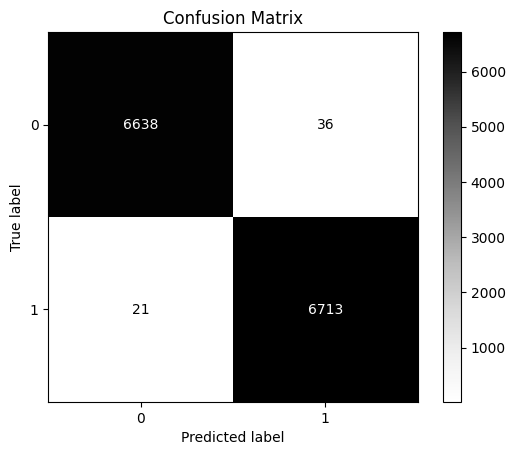

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_new_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Greys')
plt.title("Confusion Matrix")
plt.show()

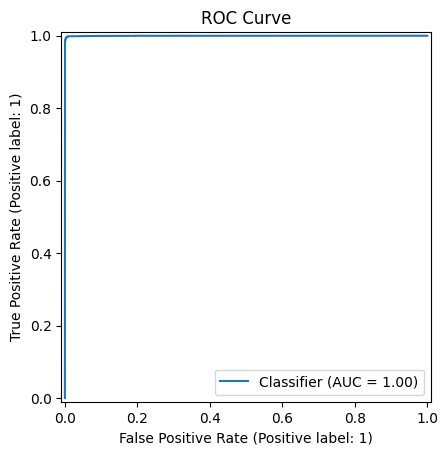

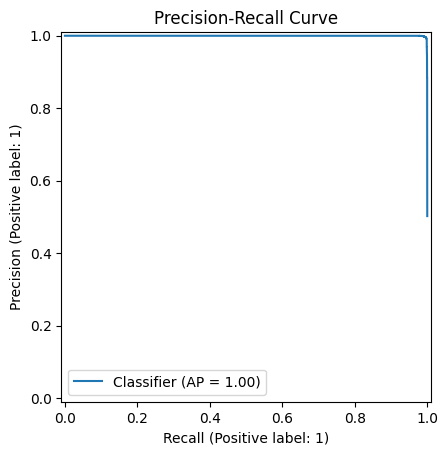

In [45]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# ROC Curve
RocCurveDisplay.from_predictions(y_new_test, y_prob).ax_.set_title("ROC Curve")
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_new_test, y_prob).ax_.set_title("Precision-Recall Curve")
plt.show()
